# Import

In [2]:
import json
# import pandas as pd
import os
import json
# import cv2
import numpy as np
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
# from matplotlib.collections import PatchCollection
from tqdm import tqdm
import imagehash
import shutil

In [3]:
origin_image_folder = "./training/origin_images/"  # 이미지가 있는 폴더 경로
origin_label_folder = "./training/origin_labels/"  # 이미지가 있는 폴더 경로

image_folder = "./training/images/"  # 중복을 제외한 이미지를 복사할 폴더 경로
label_folder = "./training/labels/"  # 이미지가 있는 폴더 경로
mask_folder = './training/masks/'

# Image Hash Value Comparison

In [10]:
image_paths = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# 이미지 해시값 저장을 위한 딕셔너리
hash_dict = {}

# 이미지 해시값 계산 및 저장
for image_path in tqdm(image_paths):
    img = Image.open(os.path.join(image_folder, image_path))
    img_hash = imagehash.average_hash(img)
    hash_dict[image_path] = img_hash

# 중복된 이미지 식별 및 제거
duplicates = {}
for image_path, img_hash in tqdm(hash_dict.items()):
    if img_hash in duplicates:
        duplicates[img_hash].append(image_path)
    else:
        duplicates[img_hash] = [image_path]

100%|██████████| 40000/40000 [00:02<00:00, 19860.30it/s]


In [11]:
# 중복된 이미지를 제외하고 한 장만 저장
for img_hash, duplicate_list in tqdm(duplicates.items()):
    if len(duplicate_list) > 1:
        # 중복된 이미지 중 첫 번째 이미지를 복사하여 저장
        src_path = os.path.join(image_folder, duplicate_list[0])
        dest_path = os.path.join(image_folder, duplicate_list[0])
        shutil.copyfile(src_path, dest_path)
        
        # 매치되는 JSON 파일도 복사
        json_filename = os.path.splitext(duplicate_list[0])[0] + ".json"
        src_json_path = os.path.join(origin_label_folder, json_filename)
        dest_json_path = os.path.join(label_folder, json_filename)
        shutil.copyfile(src_json_path, dest_json_path)
    else:
        # 중복이 없는 경우 그냥 복사
        src_path = os.path.join(image_folder, duplicate_list[0])
        dest_path = os.path.join(image_folder, duplicate_list[0])
        shutil.copyfile(src_path, dest_path)
        
        # 매치되는 JSON 파일도 복사
        json_filename = os.path.splitext(duplicate_list[0])[0] + ".json"
        src_json_path = os.path.join(origin_label_folder, json_filename)
        dest_json_path = os.path.join(label_folder, json_filename)
        shutil.copyfile(src_json_path, dest_json_path)

100%|██████████| 13456/13456 [01:57<00:00, 114.04it/s]


# Labeling Visualization

In [ ]:
# JSON 파일 목록 가져오기
json_files = [f for f in os.listdir(label_folder) if f.endswith('.json')]

# 랜덤하게 10개의 JSON 파일 선택
selected_json_files = random.sample(json_files, 10)

# 선택한 JSON 파일들을 순회하며 시각화
for json_filename in selected_json_files:
    json_path = os.path.join(label_folder, json_filename)
    image_filename = json_filename.replace('.json', '.jpg')  # 이미지 확장자에 맞게 수정
    image_path = os.path.join(origin_image_folder, image_filename)

    # JSON 파일 읽기
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)

    # 이미지 열기
    img = Image.open(image_path)

    # 이미지 크게 출력하기 위한 설정
    figsize = (15, 10)  # 원하는 크기로 수정
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    
    # 다각형 그리기
    num_objects = 0  # 객체 수 초기화
    num_polygons = 0  # 그려진 다각형 수 초기화
    for annotation in data["Annotation"]:
        if annotation["Type"] == "polygon":
            num_objects += 1
            label = annotation["Label"]
            coordinates = annotation["Coordinate"][0]  # 첫 번째 리스트 내부의 좌표들
            color = plt.cm.get_cmap('tab20')(hash(label) % 20)  # 레이블별로 다른 색상 지정
            polygon_coords = [(x, y) for x, y in zip(coordinates[::2], coordinates[1::2])]  # x, y 쌍으로 변환
            polygon = Polygon(polygon_coords, closed=True, edgecolor=color, facecolor="none", linewidth=3)
            ax.add_patch(polygon)
            ax.text(polygon_coords[0][0], polygon_coords[0][1], label, color=color, fontsize=10, backgroundcolor="black")  # 레이블 표시
            num_polygons += 1
    
    plt.title(json_filename)
    plt.show()
    
    # 출력 객체 및 다각형 수
    print(f"JSON 파일 '{json_filename}'의 객체 수: {num_objects}")
    print(f"JSON 파일 '{json_filename}'에 그려진 다각형 수: {num_polygons}")

# Object Count Distribution

  0%|          | 0/13456 [00:00<?, ?it/s]

100%|██████████| 13456/13456 [00:21<00:00, 613.28it/s] 


객체 수 평균 값: 63.77


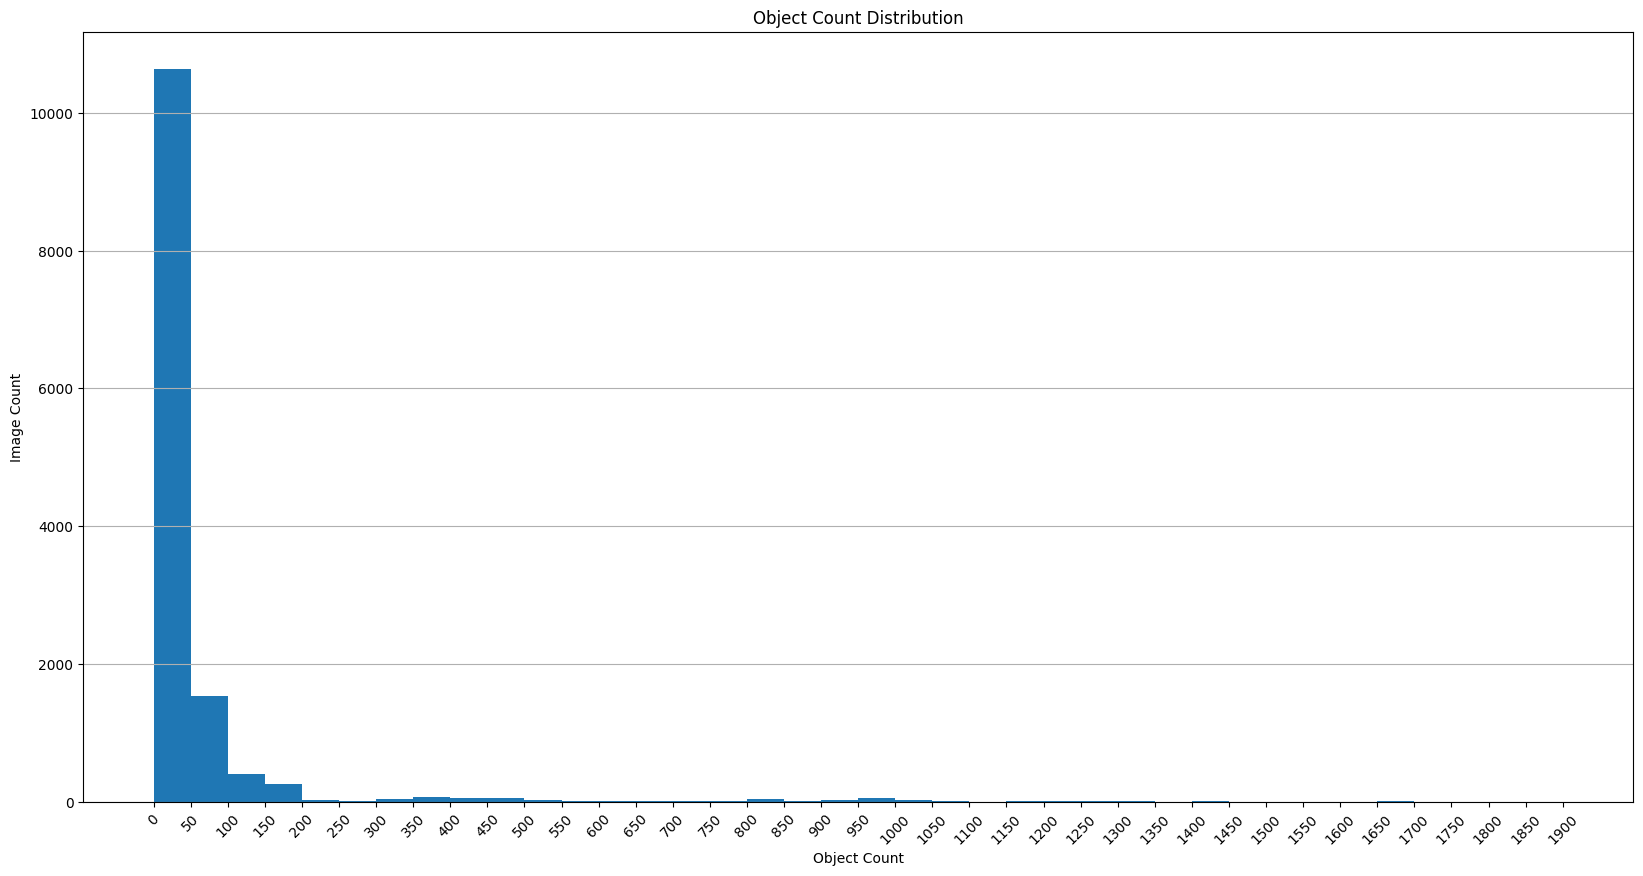

In [4]:
# JSON 파일 목록 가져오기
json_files = [f for f in os.listdir(label_folder) if f.endswith('.json')]

# 이미지당 객체 수 저장할 딕셔너리 초기화
object_count_dict = {}

# JSON 파일을 순회하며 객체 수 분석
for json_filename in tqdm(json_files):
    json_path = os.path.join(label_folder, json_filename)
    
    # JSON 파일 읽기
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)
        
        # 객체 수 계산
        object_count = sum(len(annotation["Coordinate"]) for annotation in data["Annotation"])
        
        # 이미지당 객체 수 딕셔너리에 저장
        object_count_dict[json_filename] = object_count

# 객체 수 평균 값 계산
average_object_count = sum(object_count_dict.values()) / len(object_count_dict)
print(f"객체 수 평균 값: {average_object_count:.2f}")

# 이미지당 객체 수에 따라 범위별로 분류
bins = list(range(0, max(object_count_dict.values()), 50))  # 변경된 부분: 5단위로 변경
hist, _ = np.histogram(list(object_count_dict.values()), bins=bins)

# 그래프 그리기
plt.figure(figsize=(20, 10))
plt.bar(bins[:-1], hist, width=50, align='edge')  # 변경된 부분: width=5, bins[:-1] 사용
plt.xlabel('Object Count')
plt.ylabel('Image Count')
plt.title('Object Count Distribution')
plt.xticks(bins, rotation=45)
plt.grid(axis='y')
plt.show()

## Image Screening

In [5]:
# JSON 파일 목록 가져오기
json_files = [f for f in os.listdir(label_folder) if f.endswith('.json')]

files_to_delete=[]

# 선택한 JSON 파일들을 순회하며 시각화
for json_filename in tqdm(json_files):
    json_path = os.path.join(label_folder, json_filename)

    # JSON 파일 읽기
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)

    # 다각형 그리기
    num_objects = 0  # 객체 수 초기화
    for annotation in data["Annotation"]:
        if annotation["Type"] == "polygon":
            num_objects += 1

    if num_objects <300:
        continue
    else:
        files_to_delete.append(json_filename)

100%|██████████| 13456/13456 [00:21<00:00, 618.08it/s] 


In [6]:
print(len(files_to_delete))

567


In [7]:
# 파일 삭제
for file_to_delete in files_to_delete:
    json_path = os.path.join(label_folder, file_to_delete)
    image_filename = file_to_delete.replace('.json', '.jpg')
    image_path = os.path.join(image_folder, image_filename)

    # 파일 삭제
    os.remove(json_path)
    os.remove(image_path)

print(f"JSON 파일 및 해당 이미지 삭제 완료.")

JSON 파일 및 해당 이미지 삭제 완료.


### Check Image

In [ ]:
# JSON 파일 목록 가져오기
json_files = [f for f in os.listdir(label_folder) if f.endswith('.json')]

# 선택한 JSON 파일들을 순회하며 시각화
for json_filename in json_files:
    json_path = os.path.join(label_folder, json_filename)
    image_filename = json_filename.replace('.json', '.jpg')  # 이미지 확장자에 맞게 수정
    image_path = os.path.join(origin_image_folder, image_filename)

    # JSON 파일 읽기
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)

    # 이미지 열기
    img = Image.open(image_path)

    # 이미지 크게 출력하기 위한 설정
    figsize = (15, 10)  # 원하는 크기로 수정
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    
    # 다각형 그리기
    num_objects = 0  # 객체 수 초기화
    num_polygons = 0  # 그려진 다각형 수 초기화
    for annotation in data["Annotation"]:
        if annotation["Type"] == "polygon":
            num_objects += 1
            label = annotation["Label"]
            coordinates = annotation["Coordinate"][0]  # 첫 번째 리스트 내부의 좌표들
            color = plt.cm.get_cmap('tab20')(hash(label) % 20)  # 레이블별로 다른 색상 지정
            polygon_coords = [(x, y) for x, y in zip(coordinates[::2], coordinates[1::2])]  # x, y 쌍으로 변환
            polygon = Polygon(polygon_coords, closed=True, edgecolor=color, facecolor="none", linewidth=1)
            ax.add_patch(polygon)
            ax.text(polygon_coords[0][0], polygon_coords[0][1], label, color=color, fontsize=10, backgroundcolor="black")  # 레이블 표시
            num_polygons += 1
    
    plt.title(json_filename)
    plt.show()
    
    # 출력 객체 및 다각형 수
    print(f"JSON 파일 '{json_filename}'의 객체 수: {num_objects}")
    print(f"JSON 파일 '{json_filename}'에 그려진 다각형 수: {num_polygons}")

## Class Distribution Analysis

  0%|          | 0/12889 [00:00<?, ?it/s]

100%|██████████| 12889/12889 [00:11<00:00, 1079.03it/s]


Class road: 16200 samples
Class sidewalk: 9651 samples
Class sky: 19101 samples
Class building: 20367 samples
Class guardrail: 5905 samples
Class pole: 25522 samples
Class traffic_light: 11700 samples
Class vegetation: 12317 samples
Class curb: 3967 samples
Class full_line: 16283 samples
Class crosswalk: 1551 samples
Class motorcycle: 1120 samples
Class dotted_line: 28630 samples
Class traffic_sign: 26733 samples
Class vehicle: 61925 samples
Class pedestrian: 4790 samples
Class road_mark: 5367 samples
Class mountain: 3844 samples
Class bridge: 408 samples
Class static: 1292 samples
Class speed_bump: 134 samples
Class parking_place: 1395 samples
Class rider: 801 samples
Class water: 46 samples
Class bicycle: 471 samples


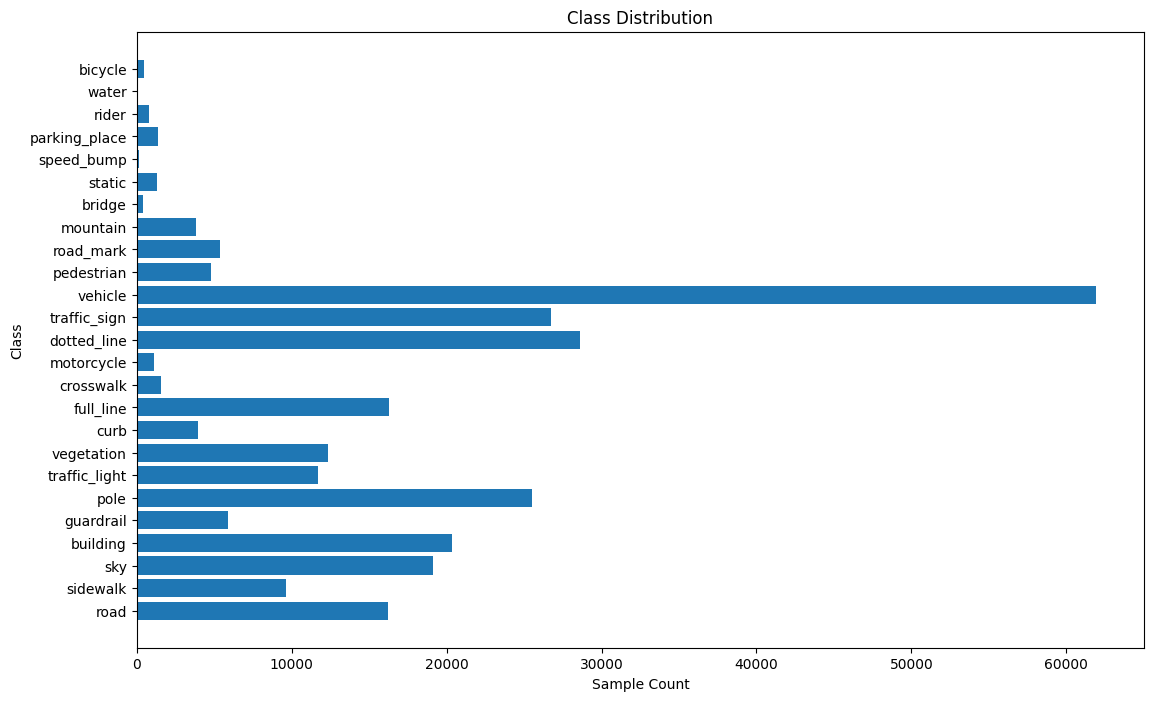

In [9]:
# 클래스별 샘플 수를 저장할 딕셔너리 초기화
class_counts = {}

# JSON 파일 목록 가져오기
json_files = [f for f in os.listdir(label_folder) if f.endswith('.json')]

# 클래스별 샘플 수 계산
for json_filename in tqdm(json_files):
    json_path = os.path.join(label_folder, json_filename)
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)
        
        # 클래스 정보 추출
        for annotation in data["Annotation"]:
            if annotation["Type"] == "polygon":
                class_name = annotation["Label"]
                if class_name=="undefined_object/area":
                    continue
                
                if class_name in class_counts:
                    class_counts[class_name] += 1
                else:
                    class_counts[class_name] = 1

# 클래스별 샘플 수 출력
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count} samples")

# 클래스별 샘플 수 시각화
classes = list(class_counts.keys())
sample_counts = list(class_counts.values())

plt.figure(figsize=(13, 8))  # 그래프 크기 조정
plt.barh(classes, sample_counts)  # 가로 막대 그래프 사용
plt.ylabel('Class')
plt.xlabel('Sample Count')
plt.title('Class Distribution')
plt.show()